In [13]:
import numpy as np

# [Problem 1] Fully Connected Layer
class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.optimizer = optimizer

    def forward(self, X):
        self.X = X
        return np.dot(X, self.W) + self.B

    def backward(self, dA):
        batch_size = self.X.shape[0]
        self.dW = np.dot(self.X.T, dA) / batch_size
        self.dB = np.mean(dA, axis=0)
        dZ = np.dot(dA, self.W.T)
        self.optimizer.update(self)
        return dZ

#[Problem 2] Classifying the initialization method
class SimpleInitializer:
    def __init__(self, sigma=0.01):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)
    def B(self, n_nodes2):
        return np.zeros(n_nodes2)

# [Problem 3] Optimizers
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB

# [Problem 4] Activation Functions
class Sigmoid:
    def forward(self, X):
        self.A = 1 / (1 + np.exp(-X))
        return self.A
    def backward(self, dZ):
        return dZ * self.A * (1 - self.A)

class SoftmaxCrossEntropy:
    def forward(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        self.A = exp_Z / np.sum(exp_Z, axis=1, keepdims=True)
        return self.A
    def backward(self, Z, Y):
        batch_size = Y.shape[0]
        return (self.A - Y) / batch_size
#[Problem 5] ReLU class creation
class ReLU:
    def forward(self, X):
        self.mask = (X > 0)
        return np.maximum(0, X)
    def backward(self, dZ):
        return dZ * self.mask

#[Problem 6] Initial value of weight
class XavierInitializer:
    def W(self, n_nodes1, n_nodes2):
        sigma = 1.0 / np.sqrt(n_nodes1)
        return sigma * np.random.randn(n_nodes1, n_nodes2)
    def B(self, n_nodes2):
        return np.zeros(n_nodes2)

class HeInitializer:
    def W(self, n_nodes1, n_nodes2):
        sigma = np.sqrt(2.0 / n_nodes1)
        return sigma * np.random.randn(n_nodes1, n_nodes2)
    def B(self, n_nodes2):
        return np.zeros(n_nodes2)

#[Problem 7] Optimization method
class AdaGrad:
    def __init__(self, lr=0.01, epsilon=1e-8):
        self.lr = lr
        self.epsilon = epsilon
    def update(self, layer):
        if not hasattr(layer, "h_W"):
            layer.h_W = np.zeros_like(layer.W)
            layer.h_B = np.zeros_like(layer.B)
        layer.h_W += layer.dW ** 2
        layer.h_B += layer.dB ** 2
        layer.W -= self.lr * layer.dW / (np.sqrt(layer.h_W) + self.epsilon)
        layer.B -= self.lr * layer.dB / (np.sqrt(layer.h_B) + self.epsilon)

In [17]:
#[Problem 8] Class completion
class ScratchDeepNeuralNetworkClassifier:
    def __init__(self, n_features, n_hidden_nodes_list, n_output,
                 initializer, optimizer, activations):
        self.layers = []
        self.activations = activations
        layer_sizes = [n_features] + n_hidden_nodes_list + [n_output]

        for i in range(len(layer_sizes) - 1):
            fc = FC(layer_sizes[i], layer_sizes[i+1], initializer, optimizer)
            self.layers.append(fc)

    def forward(self, X):
        A = X
        for layer, activation in zip(self.layers, self.activations):
            Z = layer.forward(A)
            A = activation.forward(Z)
        return A

    def backward(self, Z_last, Y):
        dA = self.activations[-1].backward(Z_last, Y)
        for i in reversed(range(len(self.layers))):
            dZ = self.layers[i].backward(dA)
            if i != 0:
                dA = self.activations[i-1].backward(dZ)

    def fit(self, X_train, Y_train, X_val, Y_val, epochs=20, batch_size=64):
        self.train_loss = []
        self.val_loss = []

        for epoch in range(epochs):
            idx = np.random.permutation(X_train.shape[0])
            X_train = X_train[idx]
            Y_train = Y_train[idx]

            for start in range(0, X_train.shape[0], batch_size):
                end = start + batch_size
                X_batch = X_train[start:end]
                Y_batch = Y_train[start:end]

                Z_last = self.forward(X_batch)
                self.backward(Z_last, Y_batch)

            train_pred = self.forward(X_train)
            val_pred = self.forward(X_val)
            train_loss_epoch = -np.mean(np.sum(Y_train * np.log(train_pred + 1e-7), axis=1))
            val_loss_epoch = -np.mean(np.sum(Y_val * np.log(val_pred + 1e-7), axis=1))

            self.train_loss.append(train_loss_epoch)
            self.val_loss.append(val_loss_epoch)

            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss_epoch:.4f}, Val Loss: {val_loss_epoch:.4f}")

    def predict(self, X):
        Z_last = self.forward(X)
        return np.argmax(Z_last, axis=1)

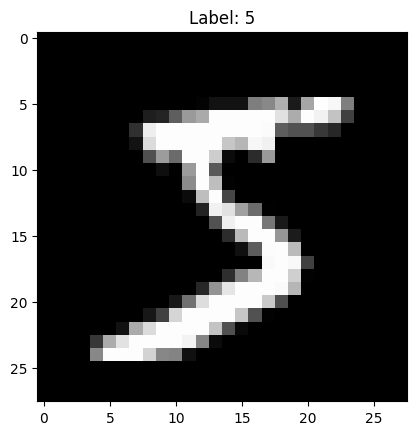

Epoch 1/10 - Train Loss: 0.2492, Val Loss: 0.2481
Epoch 2/10 - Train Loss: 0.1887, Val Loss: 0.1921
Epoch 3/10 - Train Loss: 0.1580, Val Loss: 0.1637
Epoch 4/10 - Train Loss: 0.1385, Val Loss: 0.1473
Epoch 5/10 - Train Loss: 0.1245, Val Loss: 0.1353
Epoch 6/10 - Train Loss: 0.1148, Val Loss: 0.1267
Epoch 7/10 - Train Loss: 0.1059, Val Loss: 0.1191
Epoch 8/10 - Train Loss: 0.0986, Val Loss: 0.1129
Epoch 9/10 - Train Loss: 0.0927, Val Loss: 0.1093
Epoch 10/10 - Train Loss: 0.0879, Val Loss: 0.1048
Test Accuracy: 0.9695


In [18]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import numpy as np

#[Problem 9] Learning and estimation

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 28*28).astype(np.float32) / 255.0
X_test = X_test.reshape(-1, 28*28).astype(np.float32) / 255.0

plt.imshow(X_train[0].reshape(28, 28), cmap="gray")
plt.title(f"Label: {y_train[0]}")
plt.show()

def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y]

y_train_onehot = one_hot_encode(y_train, 10)
y_test_onehot = one_hot_encode(y_test, 10)



optimizer = AdaGrad(lr=0.01)
initializer = XavierInitializer()
activations = [ReLU(), Sigmoid(), SoftmaxCrossEntropy()]

model = ScratchDeepNeuralNetworkClassifier(
    n_features=784,
    n_hidden_nodes_list=[128, 64],
    n_output=10,
    initializer=initializer,
    optimizer=optimizer,
    activations=activations
)

model.fit(X_train, y_train_onehot, X_test, y_test_onehot, epochs=10, batch_size=128)


y_pred = model.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy:.4f}")


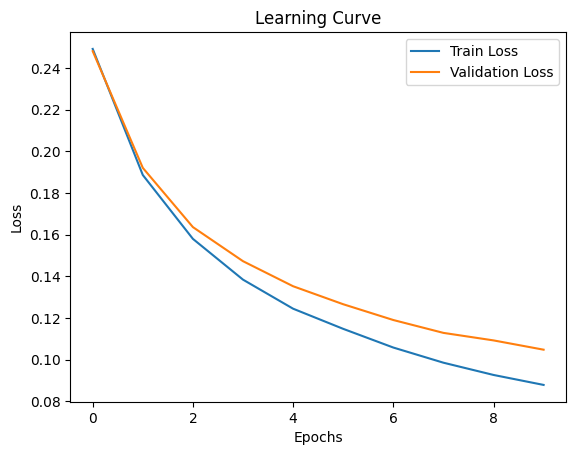

In [19]:
plt.plot(model.train_loss, label="Train Loss")
plt.plot(model.val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()